<h1>Sequence analysis</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.manifold import TSNE
import sklearn.cluster as hdbscan
#import hdbscan
from spot import spot, tools
from scipy.io import loadmat
from scipy import ndimage
from scipy.stats import median_abs_deviation as mad
from scipy.stats import kendalltau
from scipy.stats import spearmanr

In [2]:
root = '/home/vladimir/Sequences/'

In [2]:
root = '/export/home1/Sequences/'

In [4]:
root = 'D:\\Work\\Sequence analysis\\'

In [2]:
root = 'D:\\Sequences\\'

In [3]:
#Load matlab workspaces with full-featured analysis (including ripples and SCEs) of sleep session alone 
#and with place fields of that neurons in awake session
sleep_mat = loadmat(root + 'SleepPOST_all_data_new_CNMF.mat')
pf_mat = loadmat(root + 'Neurons_PFs_new_CNMF.mat')
nNeurons = pf_mat['Neurons']['PFs'][0, 0].shape[0]
#awake_mat = loadmat(root + 'Results.mat')

In [4]:
#Brutal manual cherrypicking
pc_list = np.array([1,2,4,5,7,11,15,19,20,22,23,25,30,33,35,37,38,40,43,48,49,50,51,53,54,56,57,59,61,63,65,66,70,71,72,78,82,86,90,94])-1

Text(0.5, 0, 'Size, pixels')

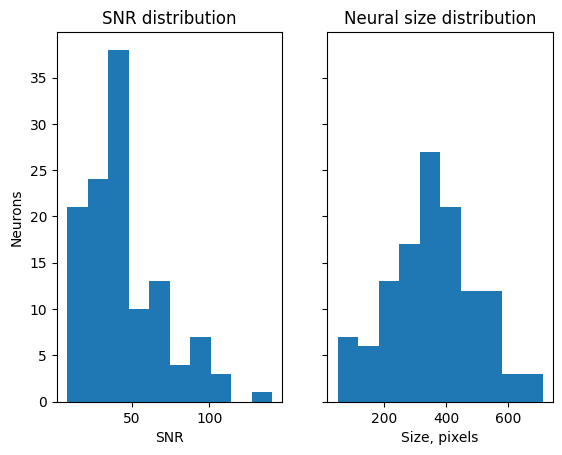

In [14]:
#Plot neuron-wise distributions of SNR and neural size (in pixels)
A = awake_mat['results']['A'][0,0].todense()
size_distrib = [np.count_nonzero(A[:,cell]) for cell in range(nNeurons)] 
mad_distrib = mad(awake_mat['results']['C_raw'][0,0], axis = 1) #Noise is estimated as Mediam Absolute Deviation (MAD)
snr_distrib = np.max(awake_mat['results']['C_raw'][0,0], axis = 1)/mad_distrib

fig, axes = plt.subplots(1,2, sharey = True)

axes[0].hist(snr_distrib)
axes[0].set_title('SNR distribution')
axes[0].set_ylabel('Neurons')
axes[0].set_xlabel('SNR')

axes[1].hist(size_distrib)
axes[1].set_title('Neural size distribution')
axes[1].set_xlabel('Size, pixels')


In [17]:
#calculate c.o.m. of all valid place fields for each neuron in each direction

pfcm = []  #2xnNeurons array of place field centers of mass for both directions for each neuron
pfdistrib = []   #2xnNeurons array of activity distributions across track for both directions for each neuron
stab_distrib = []    #list of stabilitiy values for all valid PFs of all neurons in both directions
width_distrib = []   #list of place field widths for all valid PFs of all neurons in both directions
tot_width_distrib = []   #list of sums of all place fields of 1 place cell widths for all valid PFs of all neurons in both directions
for i_dir in range(2):
    pfcm_dir = []
    pfdistrib_dir = []
    for i_neur in pc_list:
        pfs = pf_mat['Neurons']['PFs'][0, 0][i_neur, 0][i_dir]
        ispcs = pf_mat['Neurons']['isPC'][0, 0][i_neur, 0][i_dir]
        stabs = pf_mat['Neurons']['Stab'][0, 0][i_neur, 0][i_dir]
        distr = pf_mat['Neurons']['NormedSummedPlaceActivity'][0,0][0, i_neur][i_dir][0]
        neur = []
        tot_width = 0
        for pf, ispc, stab in zip(pfs, ispcs, stabs):  #loop for all PFs of a neuron i_neur in direction i_dir 
            if ispc[0][0][0]:   #here shold be a check for thresholds
                neur += pf[0][0].tolist()
                stab_distrib.append(stab[0][0][0])
                width_distrib.append(len(pf[0][0]))  
                tot_width += len(pf[0][0])

        cm = np.nan if not len(neur) else np.argmax(distr)
        #pfcm_dir.append(np.mean(neur)) 
        pfcm_dir.append(cm)
        pfdistrib_dir.append(distr)
        tot_width_distrib.append(tot_width)
    pfcm.append(pfcm_dir)
    pfdistrib.append(pfdistrib_dir)

Text(0.5, 0, "Sum of all PF's widths, bins")

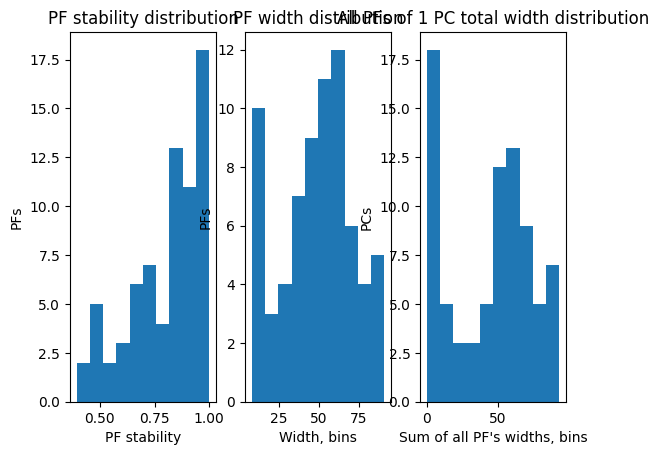

In [7]:
#plot distributions of total PF width for all neurons and repeatability + PF width for all PFs 
fig, axes = plt.subplots(1,3)

axes[0].hist(stab_distrib)
axes[0].set_title('PF stability distribution')
axes[0].set_ylabel('PFs')
axes[0].set_xlabel('PF stability')

axes[1].hist(width_distrib)
axes[1].set_title('PF width distribution')
axes[1].set_ylabel('PFs')
axes[1].set_xlabel('Width, bins')

axes[2].hist(tot_width_distrib)
axes[2].set_title('All PFs of 1 PC total width distribution')
axes[2].set_ylabel('PCs')
axes[2].set_xlabel("Sum of all PF's widths, bins")

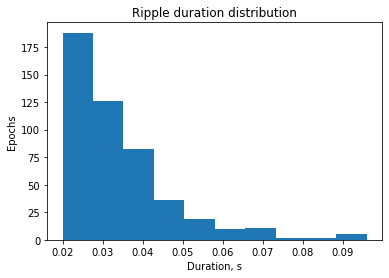

In [3]:
durs = [rip[2] - rip[0] for rip in mat['ripples']]
ax = plt.subplot()
ax.hist(durs)
ax.set_title('Ripple duration distribution')
ax.set_ylabel('Epochs')
ax.set_xlabel('Duration, s');

<Figure size 2000x2000 with 0 Axes>

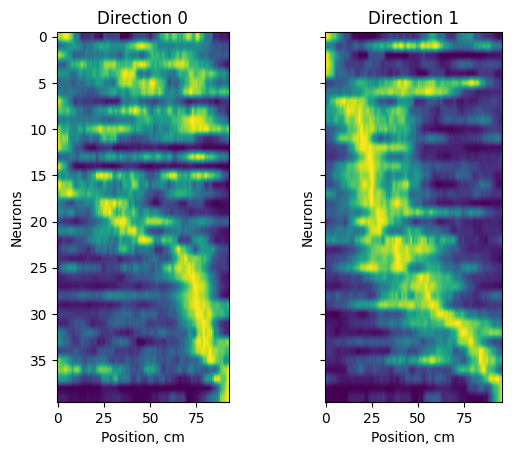

In [45]:
#Plot place field distributions
plt.figure(figsize = (20,20), dpi = 100)
fig, axes = plt.subplots(1,2, sharey = True)
for i_dir, distr in enumerate(pfdistrib):
    order = np.argsort(pfcm[i_dir])
    axes[i_dir].imshow(np.array(distr)[order], aspect = 5)
    axes[i_dir].set_title(f'Direction {i_dir}')
    axes[i_dir].set_ylabel('Neurons')
    axes[i_dir].set_xlabel('Position, cm')

In [23]:
#Construct data structure of spike times as described in SPOTDisClust for further analysis
spike_times = [] #solid massive for all spike times (relative to the epoch start) of all neurons in all epochs
ii_spike_times = [] #indices in spike_times for each neuron in each epoch, like [[[i_start, i_end], [same for the next neuron],..], [same for the next epoch],...]
duration = 0.2 #around-ripple epoch duration in seconds
fps = 100
duration_frames = int(duration*fps)
#n_neurons = len(sleep_mat['EvtStarts'])
n_neurons = len(pc_list)
nbEvents = [] #number of events per epoch
minev = 10 #minimum number of events per epoch
nbEvents_valid =[] #number of events per valid epoch (i.e., passed by minev criterium)
cnt = 0 #counter of spikes
ep_start_list = []

neurotime = sleep_mat['TTLstartsTimes']
#neurotime -= neurotime[0]

def time2ind(t):
    return np.where(neurotime >= t)[0][0]

for ripple in sleep_mat['ripples']:
    epoch = []
    ep_spike_times = []
    ep_start = time2ind(ripple[1]-duration/2)  #epoch start time in indices 
    rip_start = time2ind(ripple[0]) - ep_start #ripple start time in indicices (relative to the epoch start)
    rip_end = time2ind(ripple[2]) - ep_start   #ripple end time in indicices (relative to the epoch start)
    
    for neuron in sleep_mat['EvtStarts'][pc_list]:
        events = np.array(neuron[ep_start:ep_start + duration_frames])
        
        events[:rip_start] = 0 #drop all the events in the current epoch outside the current ripple
        events[rip_end:] = 0
        
        inds = np.nonzero(events)[0]/fps                #spike times and indices,
        ep_spike_times += inds.tolist()                 #realtive to the epoch start
        epoch.append([cnt, cnt+len(inds)])
        cnt += len(inds)
        
    if len(ep_spike_times) >= minev:
        spike_times += ep_spike_times
        ii_spike_times.append(epoch)
        nbEvents_valid.append(len(ep_spike_times))
        ep_start_list.append(ep_start)
    else:
        cnt -= len(ep_spike_times)
        
    nbEvents.append(len(ep_spike_times))
        
ii_spike_times = np.array(ii_spike_times)
nbEpochs = len(nbEvents_valid)
print(f'Constructed {nbEpochs} epochs from {len(nbEvents)} ripples\nFound {sum(nbEvents_valid)} events, av. {sum(nbEvents_valid)/nbEpochs:.1f} per epoch')

Constructed 99 epochs from 481 ripples
Found 1330 events, av. 13.4 per epoch


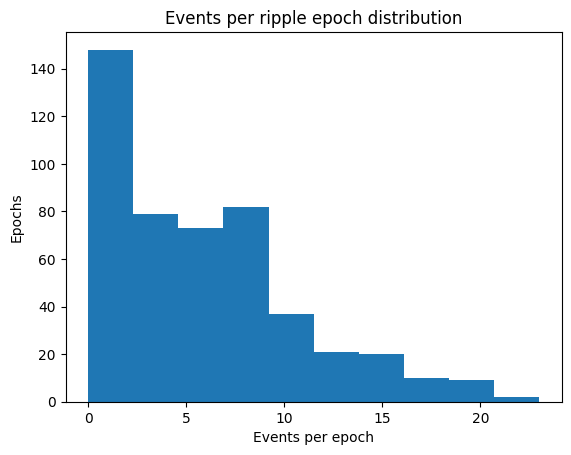

In [8]:
ax = plt.subplot()
ax.hist(nbEvents)
ax.set_title('Events per ripple epoch distribution')
ax.set_ylabel('Epochs')
ax.set_xlabel('Events per epoch');

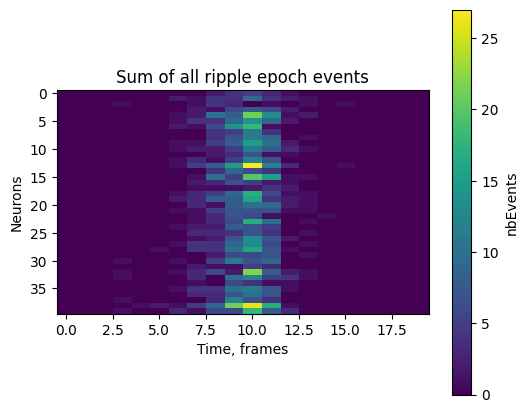

In [9]:
plt.figure(figsize = (6,5), dpi = 100)
ax = plt.subplot()
ax.set_title('Sum of all ripple epoch events')

sum_events = np.zeros((n_neurons, duration_frames)) 
for epoch in ii_spike_times:
    for i_neuron, neuron in enumerate(epoch):
        sp_indices = spike_times[neuron[0]:neuron[1]]
        for ind in sp_indices:
            sum_events[i_neuron, int(ind*fps)] += 1

plt.imshow(sum_events, aspect = 0.3) 
plt.colorbar().set_label('nbEvents')
plt.xlabel('Time, frames')
plt.ylabel('Neurons');

In [31]:
#deduct the order from the neuron-wise center of mass of summary events image
sum_cim = [ndimage.center_of_mass(row)[0] for row in sum_events]
order = np.argsort(sum_cim)

/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [98]:
#center of mass of the first epoch
first_cim = [np.mean(spike_times[row[0]:row[1]]) for row in ii_spike_times[0]] 
order = np.argsort(first_cim)

/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [20]:
pfdir = 0

In [44]:
pfdir = 1

In [21]:
dirlen = {0:93, 1:96}

colors = ['black' if np.isnan(pf) else colormap.rainbow(pf/dirlen[pfdir])[:3] for pf in pfcm[pfdir]]
col_order = np.argsort(pfcm[pfdir])

#First, sort epochs by Kendall's Tau Sortedness measure OR by Sperman Ranking test
#In fact, order of cell firing of each epoch and of pfcm sorting is compared and epochs are sorted with this obtained measure

ep_sortedness = []
for i_epoch, epoch in enumerate(ii_spike_times):
    active = [i for i, row in enumerate(epoch) if row[0] != row[1]]
    cim = [np.mean(spike_times[row[0]:row[1]]) for row in epoch] #center of mass of the activation times of each neuron
    neur_order = np.argsort([cim[i] for i in active])   #order of active neurons by c.m. of activation times (only active neurons are taken!!)
    loc_col_order = np.argsort([pfcm[pfdir][i] for i in active]) #order of the same neurons by their pfcm in awake session
    #ep_sortedness.append(kendalltau(neur_order, loc_col_order)[0])
    ep_sortedness.append(spearmanr(neur_order, loc_col_order).correlation)

ep_order = np.argsort(ep_sortedness) #oreder of epochs by theis sortedness, i.e. by the similarity of their orders (neur and loc_col)


/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vladimir/anaconda3/envs/spot/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
#Search for the maximal length of sorted subsequence in eaxh epoch 
#Sequence = monotonic interval among sorted cells
from scipy.signal import find_peaks

pfdir = 1
dirlen = {0:93, 1:96}

colors = ['black' if np.isnan(pf) else colormap.rainbow(pf/dirlen[pfdir])[:3] for pf in pfcm[pfdir]]
col_order = np.argsort(pfcm[pfdir])


def find_monotonous_intervals(arr):
    peaks, _ = find_peaks(arr, height=0)
    split_lists = np.split(arr, peaks)
    return [list(l) for l in split_lists]

sequences = []
max_length = []

for i_epoch, epoch in enumerate(ii_spike_times): 
    act_neurons = [i for i, row in enumerate(epoch[col_order]) if row[0] != row[1]]
    act_times = [np.mean(spike_times[row[0]:row[1]]) for row in epoch[col_order] if row[0] != row[1]] #center of mass of the activation times of each neuron
    
    sequences.append(find_monotonous_intervals(act_times))
    max_length.append(max([len(seq) for seq in sequences[-1]]))
    
ep_order = np.argsort(max_length)[::-1] #Descending order       
        

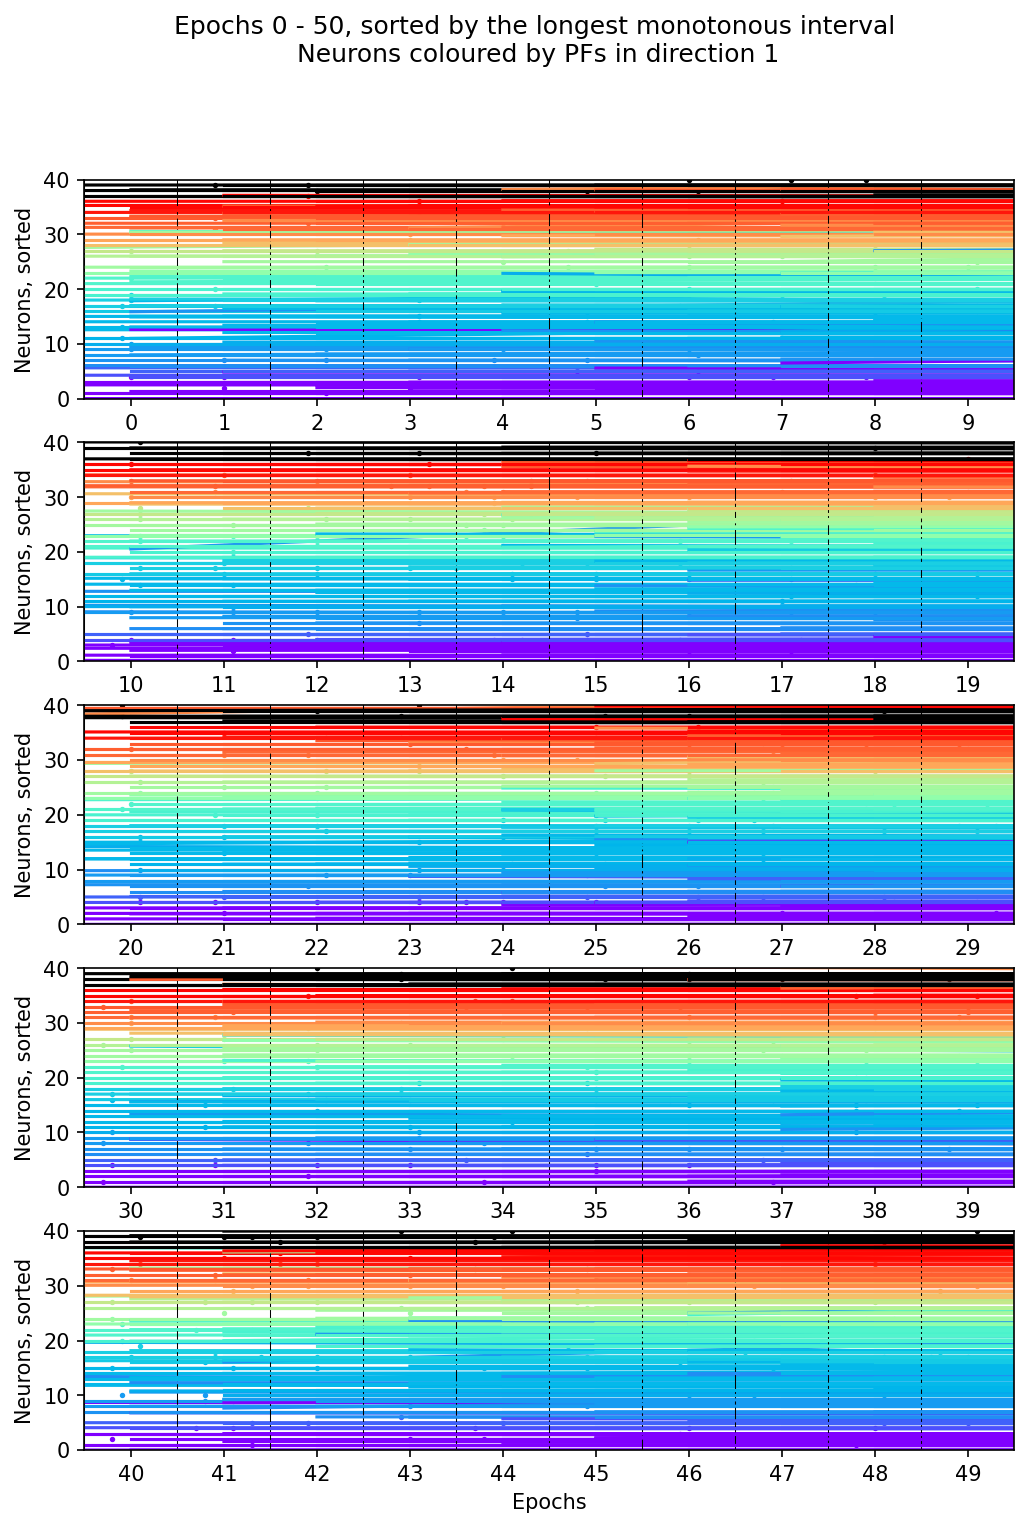

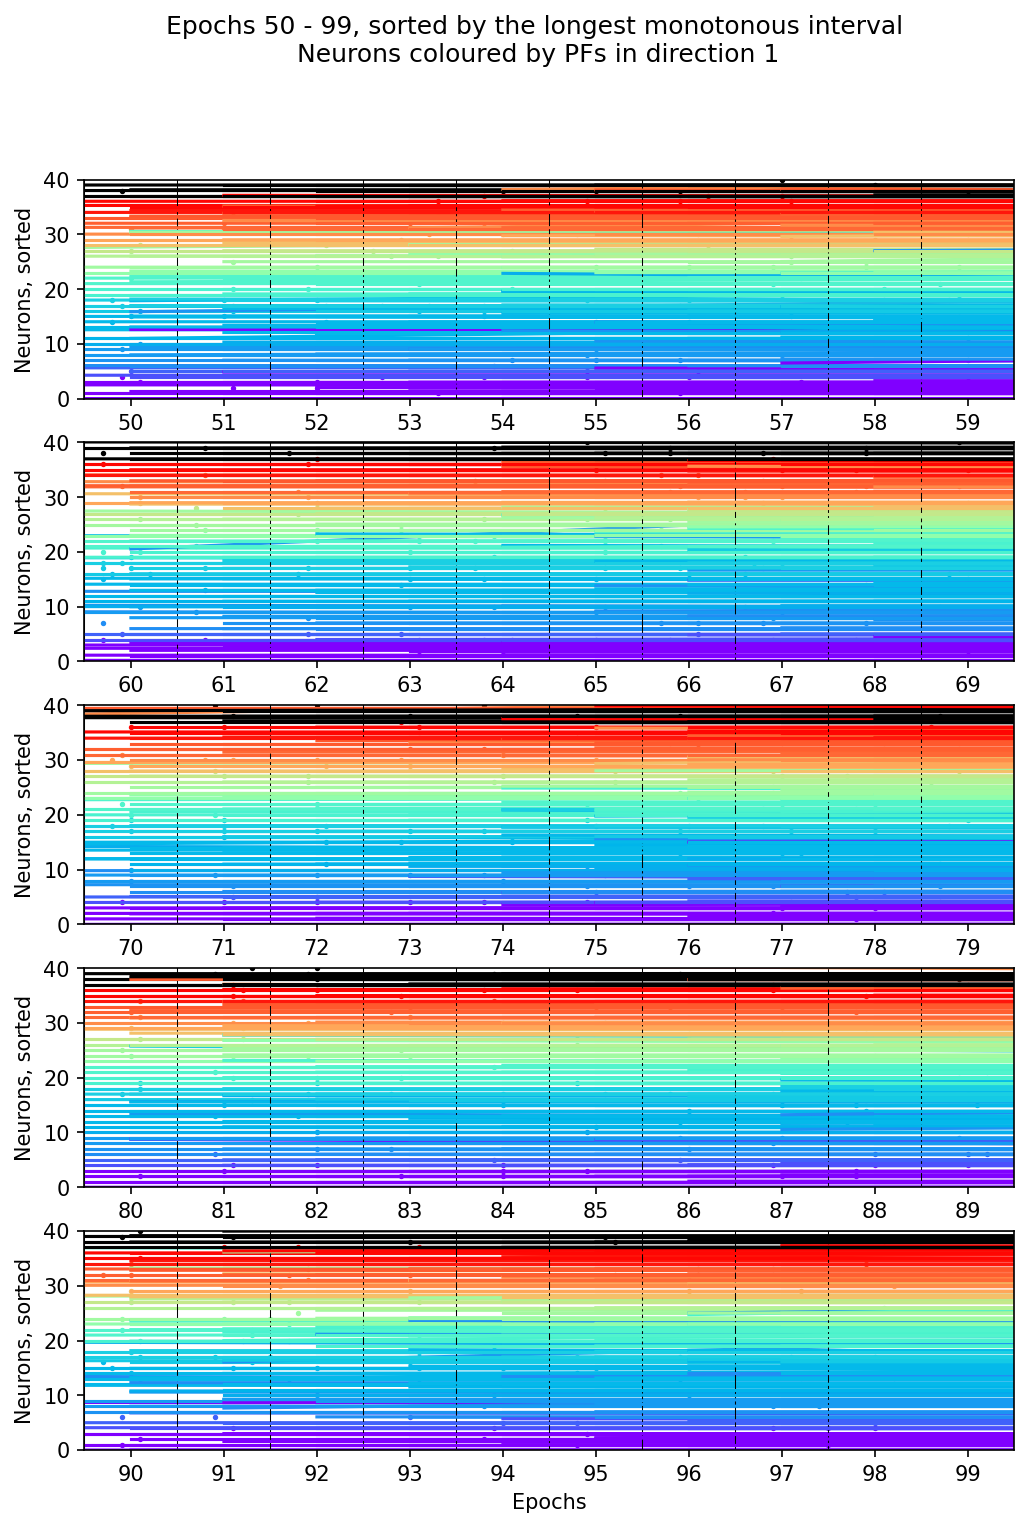

In [27]:
#Spatial 2D representation of epochs
interval = 0.1 #length between epoch centers on the plot
eps_per_row = 10 #number of epochs per row
eps_per_col = 5  #number of epochs per column
eps_per_fig = eps_per_row*eps_per_col
n_pages = int(len(ii_spike_times)/eps_per_fig) + 1
fact = 0.2 #scale factor for raw calcium plotting

pdf = PdfPages(root + f'Chrp_2D_monoton_dir{pfdir}.pdf')

for page in range(n_pages):
    fig, axes = plt.subplots(eps_per_col, 1, figsize = (8,11), dpi = 150)
    fig.suptitle(f'Epochs {page*eps_per_fig} - {min((page +1)*eps_per_fig, len(ii_spike_times))}, sorted by the longest monotonous interval\n Neurons coloured by PFs in direction {pfdir}')
    
    for a, ax in enumerate(axes):
        ax.set_xticks(np.linspace(interval, eps_per_row*interval, eps_per_row))
        ax.set_xticklabels([str(i + a*eps_per_row + page*eps_per_fig) for i in range(eps_per_row)])
        ax.set_xlim(interval*0.5, interval*(eps_per_row + 0.5))
        ax.set_ylim(0, n_neurons)
        ax.set_ylabel('Neurons, sorted')
    axes[-1].set_xlabel('Epochs')

    for i_epoch, epoch in enumerate(ii_spike_times[ep_order][page*eps_per_fig: min((page +1)*eps_per_fig, len(ii_spike_times))]):
        row = int(i_epoch/eps_per_row)
        col = i_epoch%eps_per_row
        axes[row].axvline(interval*(col + 0.5), c = 'black', linewidth=0.5)
        ep_start = ep_start_list[i_epoch]
        for i_neuron, neuron in enumerate(epoch[col_order]):
            trace = sleep_mat['ExtractedResults']['C'][0][0][i_neuron,:][ep_start:ep_start + duration_frames]
            spikes = np.array(spike_times[neuron[0]:neuron[1]])
            axes[row].scatter(spikes + interval*col, np.ones(len(spikes))+i_neuron, color=colors[col_order[i_neuron]], marker='.', s=10)
            axes[row].plot(np.linspace(interval*col, interval*col+ duration_frames-1, duration_frames), trace*fact + i_neuron, color=colors[col_order[i_neuron]])
    pdf.savefig()
pdf.close()

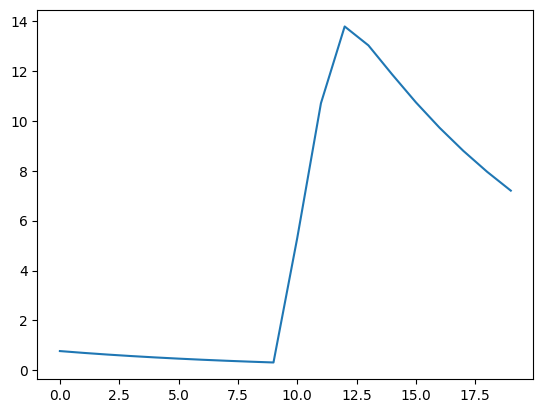

In [24]:
ep_start = ep_start_list[10]
i_neuron = 1
trace = sleep_mat['ExtractedResults']['C'][0][0][i_neuron,:][ep_start:ep_start + duration_frames]
plt.plot(trace)

In [26]:
np.linspace(0,10,10)

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

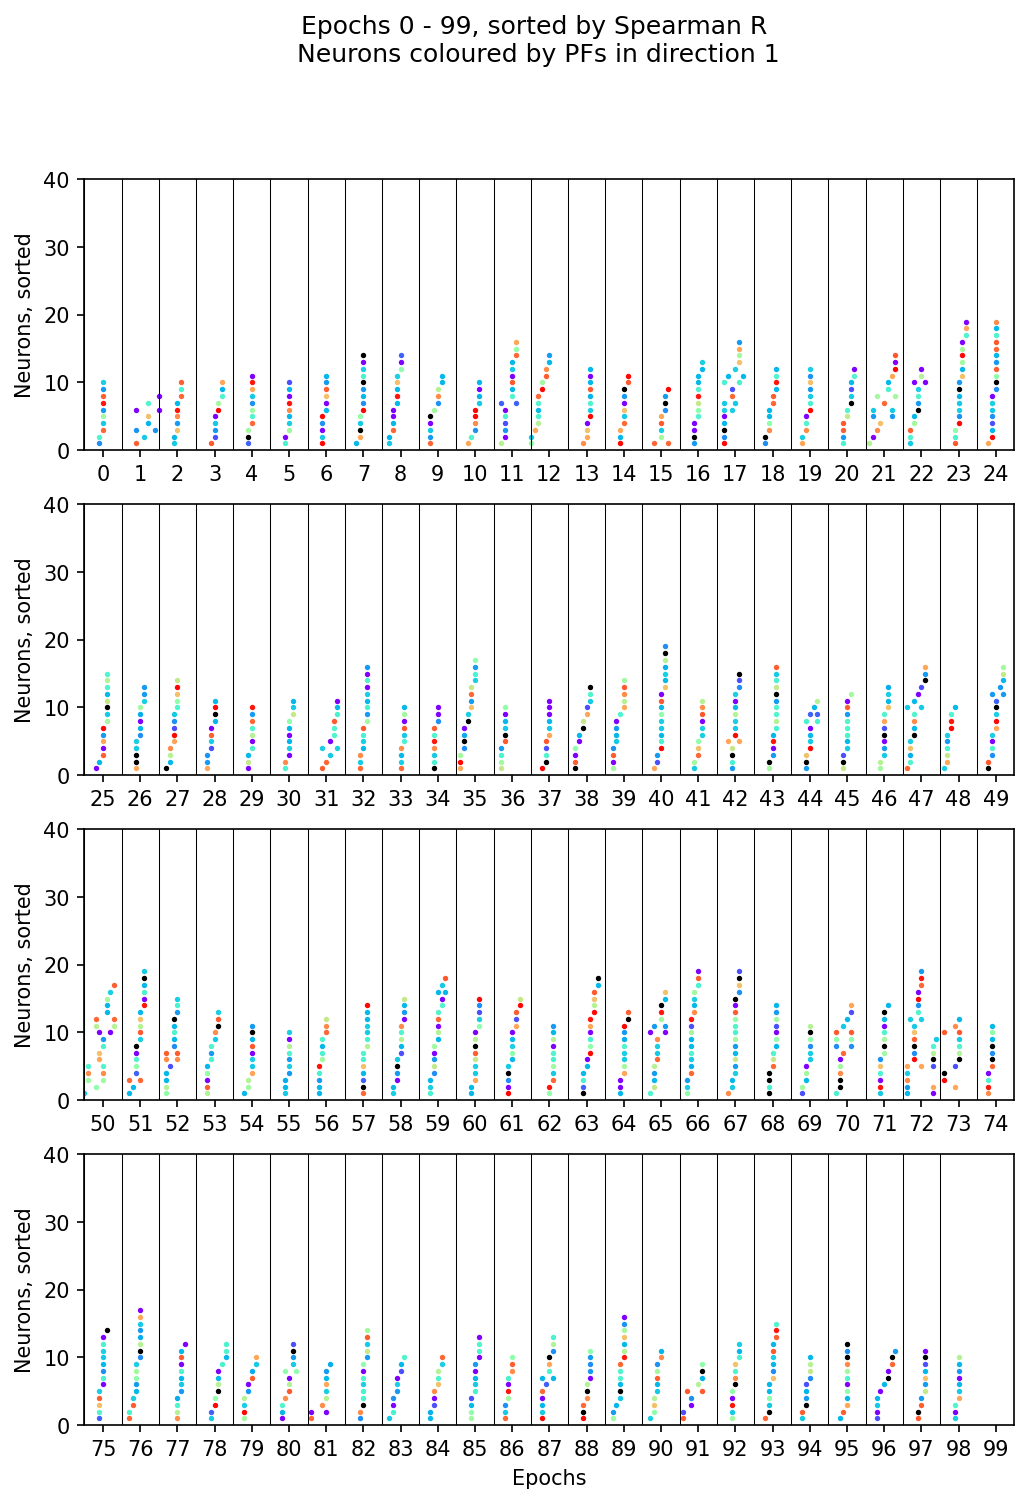

In [46]:
#Colored representation of epochs
interval = 0.1 #length between epoch centers on the plot
eps_per_row = 25 #number of epochs per row
eps_per_col = 4  #number of epochs per column
eps_per_fig = eps_per_row*eps_per_col
n_pages = int(len(ii_spike_times)/eps_per_fig) + 1

pdf = PdfPages(root + f'Chrp_spearmanr_dir{pfdir}.pdf')

for page in range(n_pages):
    fig, axes = plt.subplots(eps_per_col, 1, figsize = (8,11), dpi = 150)
    fig.suptitle(f'Epochs {page*eps_per_fig} - {min((page +1)*eps_per_fig, len(ii_spike_times))}, sorted by Spearman R\n Neurons coloured by PFs in direction {pfdir}')
    
    for a, ax in enumerate(axes):
        ax.set_xticks(np.linspace(interval, eps_per_row*interval, eps_per_row))
        ax.set_xticklabels([str(i + a*eps_per_row + page*eps_per_fig) for i in range(eps_per_row)])
        ax.set_xlim(interval*0.5, interval*(eps_per_row + 0.5))
        ax.set_ylim(0, n_neurons)
        ax.set_ylabel('Neurons, sorted')
    axes[-1].set_xlabel('Epochs')

    for i_epoch, epoch in enumerate(ii_spike_times[ep_order[page*eps_per_fig: min((page +1)*eps_per_fig, len(ii_spike_times))]]):
        row = int(i_epoch/eps_per_row)
        col = i_epoch%eps_per_row
        axes[row].axvline(interval*(col + 0.5), c = 'black', linewidth=0.5)

        cim = [np.mean(spike_times[row[0]:row[1]]) for row in epoch] 
        order = np.argsort(cim)
        for i_neuron, neuron in enumerate(epoch[order]):
            spikes = np.array(spike_times[neuron[0]:neuron[1]])
            axes[row].scatter(spikes + interval*col, np.ones(len(spikes))+i_neuron, color=colors[order[i_neuron]], marker='.', s=10)
    pdf.savefig()
pdf.close()

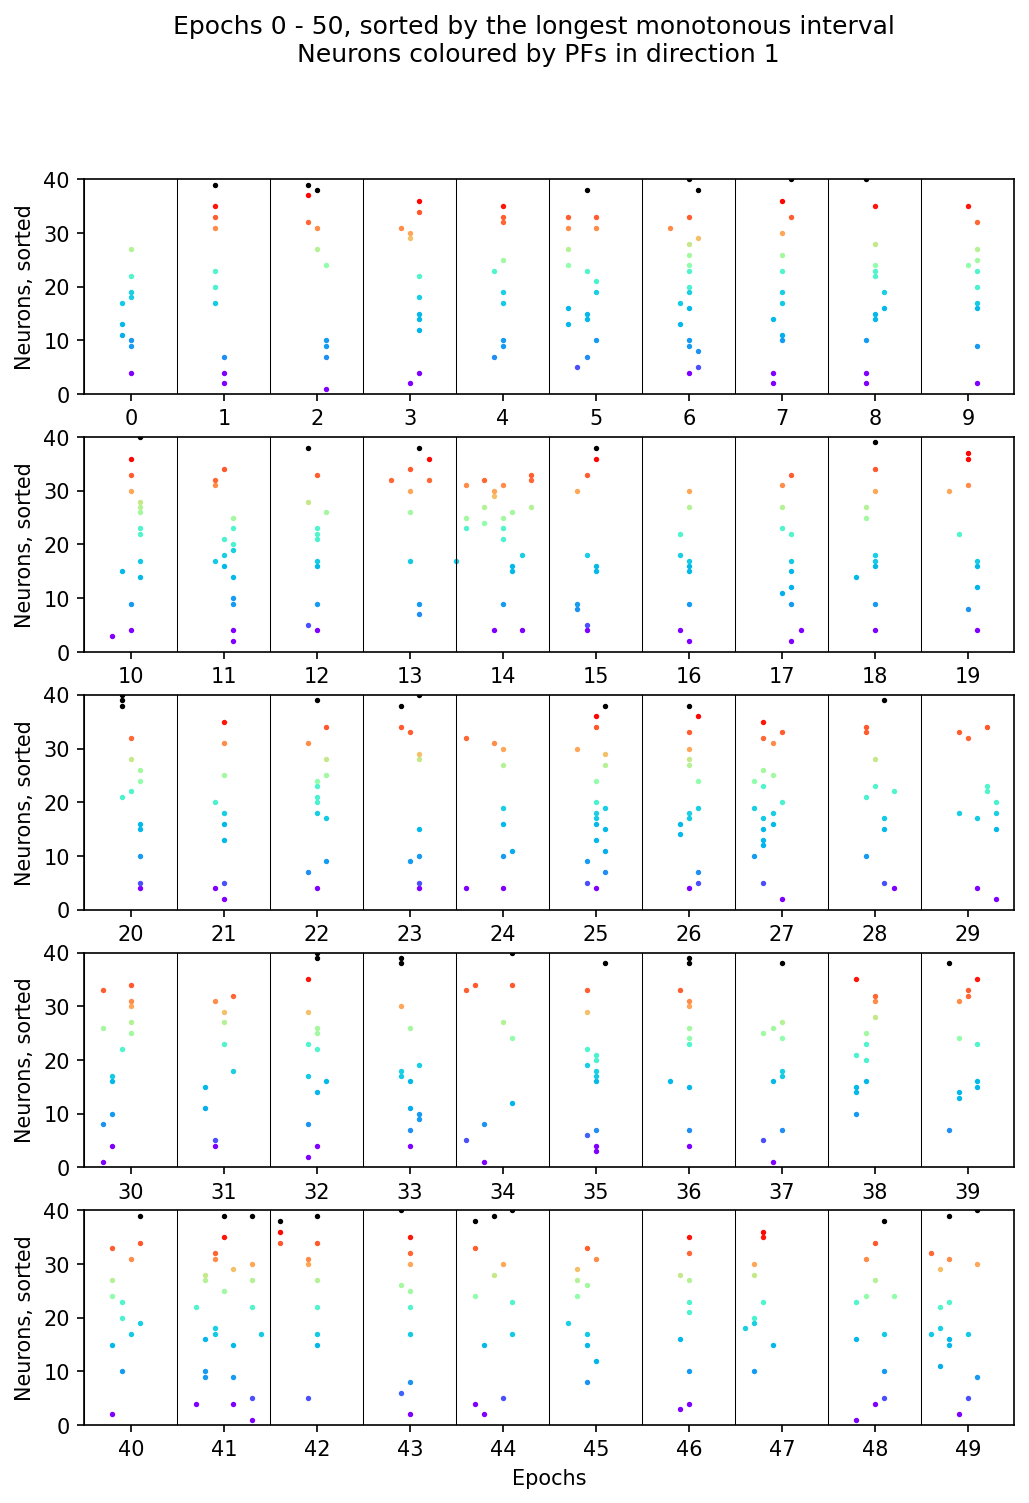

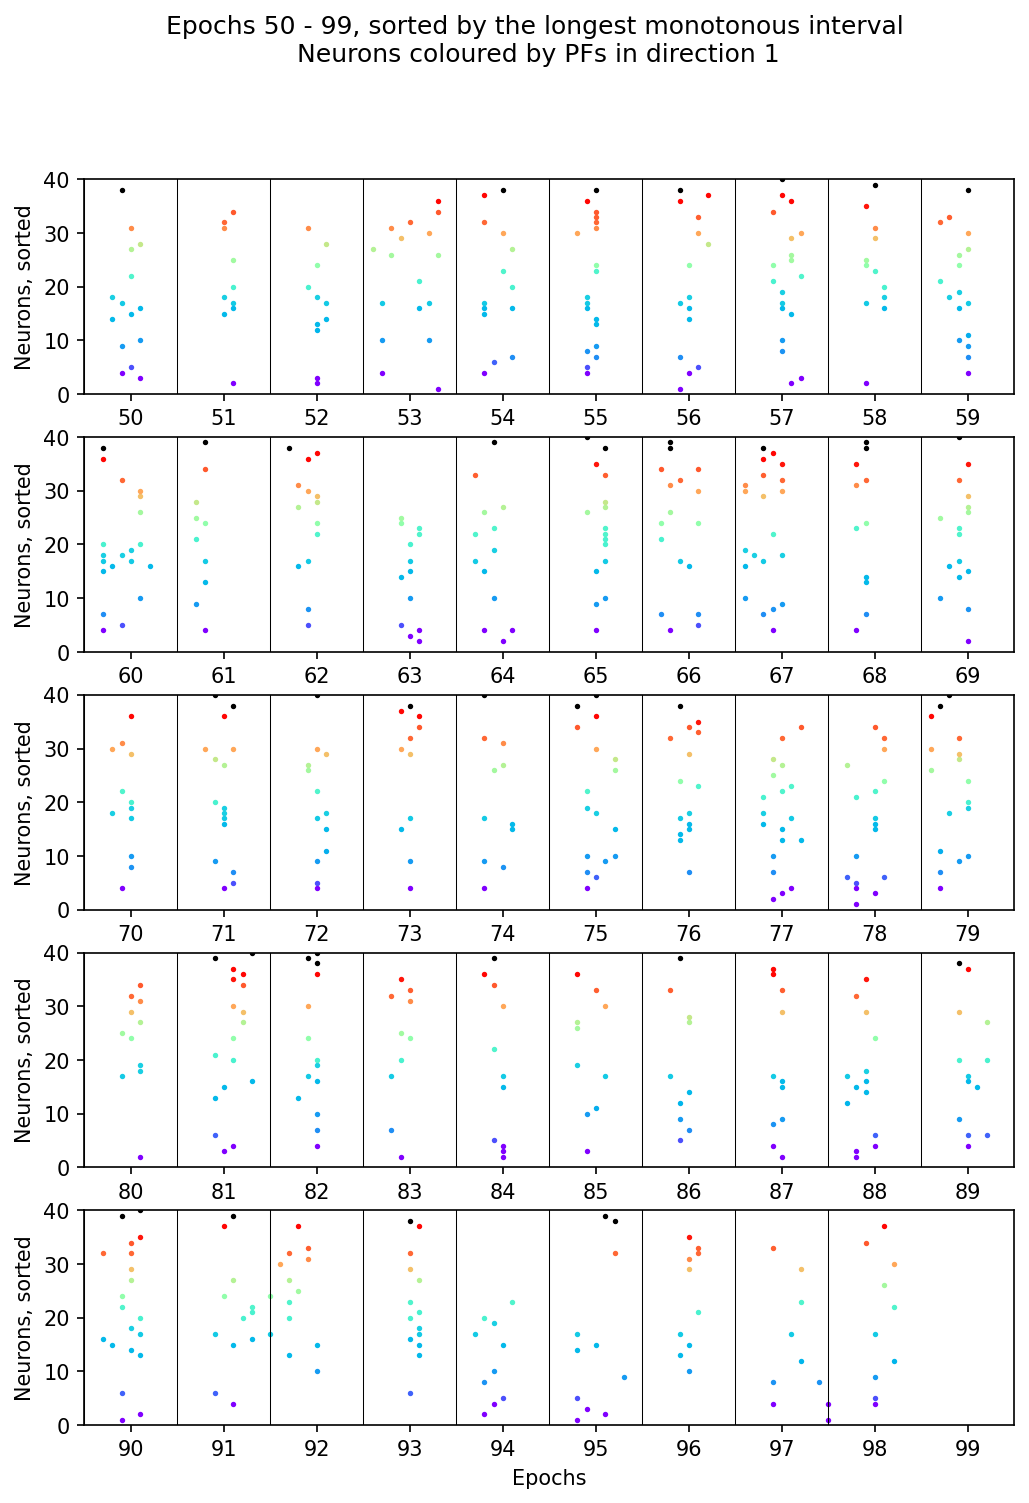

In [22]:
#Spatial 2D representation of epochs
interval = 0.1 #length between epoch centers on the plot
eps_per_row = 10 #number of epochs per row
eps_per_col = 5  #number of epochs per column
eps_per_fig = eps_per_row*eps_per_col
n_pages = int(len(ii_spike_times)/eps_per_fig) + 1

pdf = PdfPages(root + f'Chrp_2D_monoton_dir{pfdir}.pdf')

for page in range(n_pages):
    fig, axes = plt.subplots(eps_per_col, 1, figsize = (8,11), dpi = 150)
    fig.suptitle(f'Epochs {page*eps_per_fig} - {min((page +1)*eps_per_fig, len(ii_spike_times))}, sorted by the longest monotonous interval\n Neurons coloured by PFs in direction {pfdir}')
    
    for a, ax in enumerate(axes):
        ax.set_xticks(np.linspace(interval, eps_per_row*interval, eps_per_row))
        ax.set_xticklabels([str(i + a*eps_per_row + page*eps_per_fig) for i in range(eps_per_row)])
        ax.set_xlim(interval*0.5, interval*(eps_per_row + 0.5))
        ax.set_ylim(0, n_neurons)
        ax.set_ylabel('Neurons, sorted')
    axes[-1].set_xlabel('Epochs')

    for i_epoch, epoch in enumerate(ii_spike_times[ep_order][page*eps_per_fig: min((page +1)*eps_per_fig, len(ii_spike_times))]):
        row = int(i_epoch/eps_per_row)
        col = i_epoch%eps_per_row
        axes[row].axvline(interval*(col + 0.5), c = 'black', linewidth=0.5)
        for i_neuron, neuron in enumerate(epoch[col_order]):
            spikes = np.array(spike_times[neuron[0]:neuron[1]])
            axes[row].scatter(spikes + interval*col, np.ones(len(spikes))+i_neuron, color=colors[col_order[i_neuron]], marker='.', s=10)
    pdf.savefig()
pdf.close()

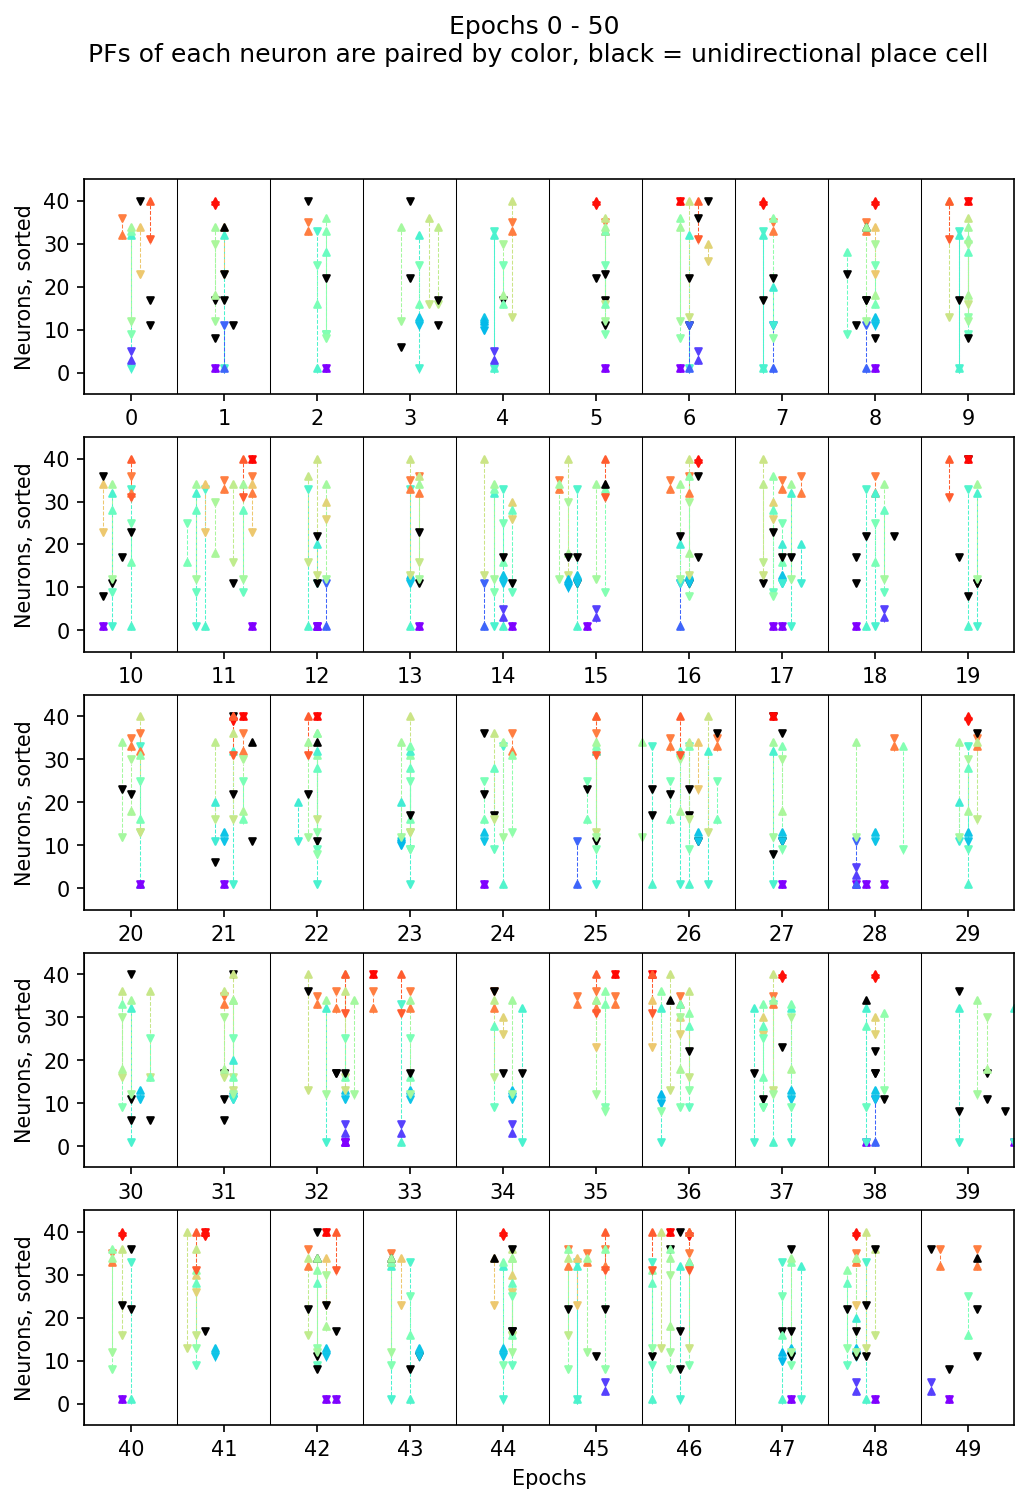

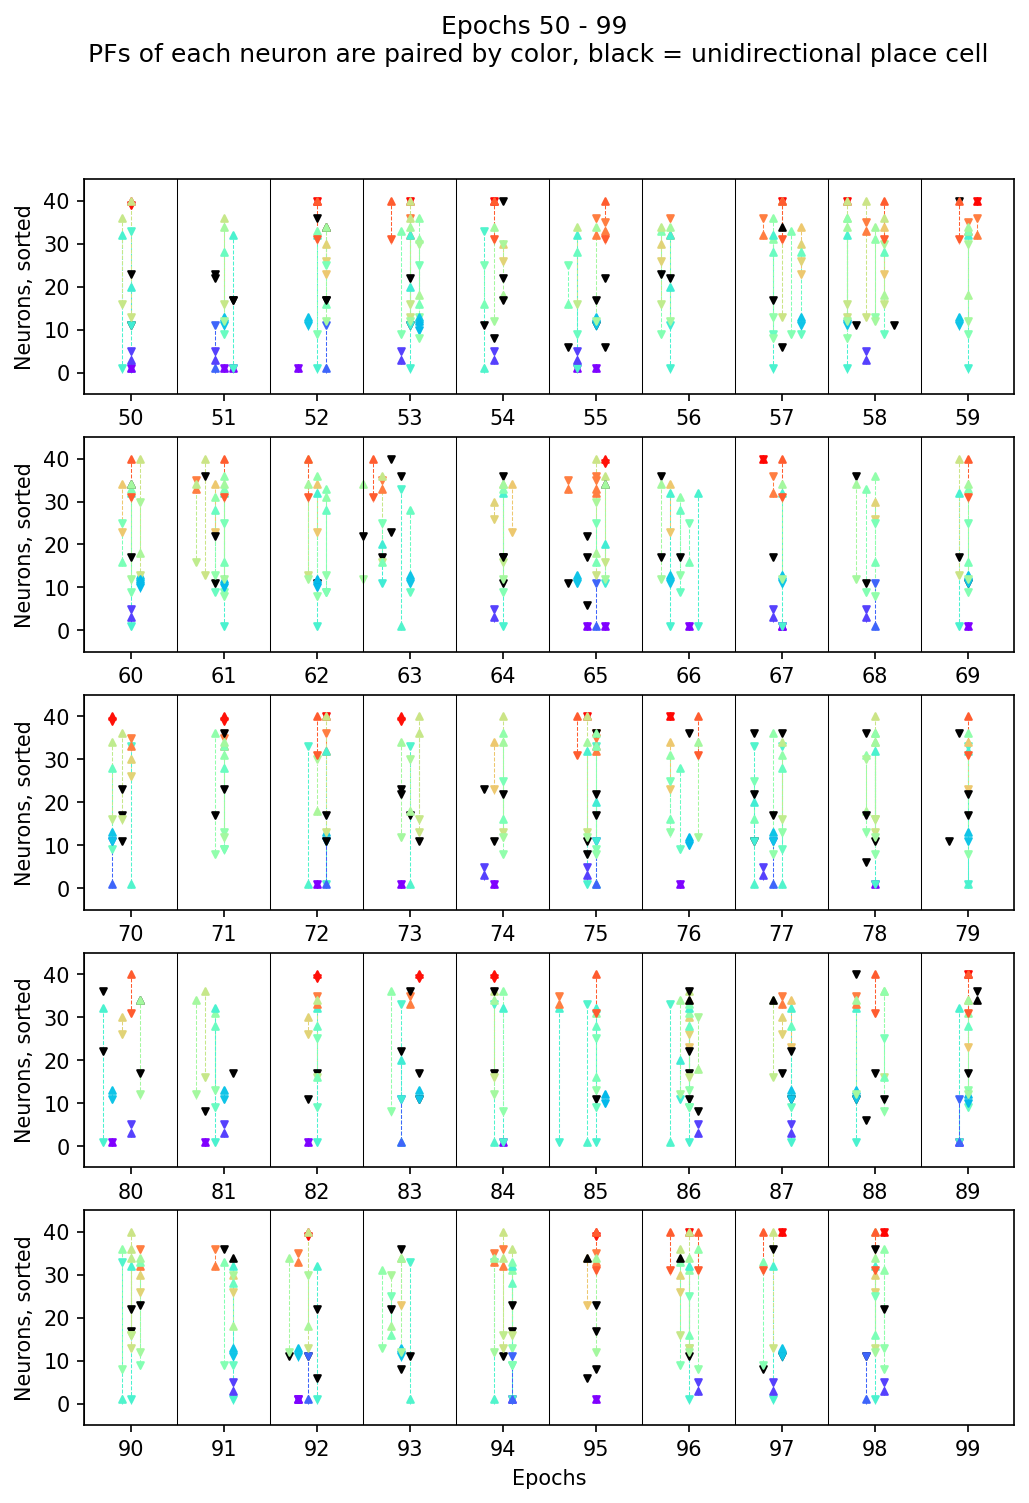

In [61]:
#Now the same, but in both directions simultaneously
interval = 0.1 #length between epoch centers on the plot
eps_per_row = 10 #number of epochs per row
eps_per_col = 5  #number of epochs per column
eps_per_fig = eps_per_row*eps_per_col
n_pages = int(len(ii_spike_times)/eps_per_fig) + 1
spacing = 5

pdf = PdfPages(root + f'Chrp_2D_bidirectional.pdf')

dirlen = {0:93, 1:96}
markers = {0:'^', 1: 'v'}

for page in range(n_pages):
    fig, axes = plt.subplots(eps_per_col, 1, figsize = (8,11), dpi = 150)
    fig.suptitle(f'Epochs {page*eps_per_fig} - {min((page +1)*eps_per_fig, len(ii_spike_times))}\n PFs of each neuron are paired by color, black = unidirectional place cell')
    
    for a, ax in enumerate(axes):
        ax.set_xticks(np.linspace(interval, eps_per_row*interval, eps_per_row))
        ax.set_xticklabels([str(i + a*eps_per_row + page*eps_per_fig) for i in range(eps_per_row)])
        ax.set_xlim(interval*0.5, interval*(eps_per_row + 0.5))
        ax.set_ylim(-spacing, n_neurons+ spacing)
        ax.set_ylabel('Neurons, sorted')
    axes[-1].set_xlabel('Epochs')

    for i_epoch, epoch in enumerate(ii_spike_times[page*eps_per_fig: min((page +1)*eps_per_fig, len(ii_spike_times))]):
        row = int(i_epoch/eps_per_row)
        col = i_epoch%eps_per_row
        axes[row].axvline(interval*(col + 0.5), c = 'black', linewidth=0.5)

        for i_neuron, neuron in enumerate(epoch):
            spikes = np.array(spike_times[neuron[0]:neuron[1]])
            color = colormap.rainbow(np.mean([pfcm[pfdir][i_neuron]/dirlen[pfdir] for pfdir in range(2)]))[:3]
            height = []
            for pfdir in range(2):
                if np.isnan(pfcm[pfdir][i_neuron]):
                    continue
                height.append(int(pfcm[pfdir][i_neuron]/dirlen[pfdir]*n_neurons))
                axes[row].scatter(spikes + interval*col, np.ones(len(spikes))+height[-1], color=color, marker=markers[pfdir], s=10)
            if len(height) > 1:
                for sp in spikes:
                    axes[row].axvline(sp + interval*col, ymin=(height[0] + spacing)/(n_neurons + 2*spacing), ymax=(height[1] + spacing)/(n_neurons + 2*spacing), color=color, linestyle = '--', linewidth =0.5, zorder = 0)
    pdf.savefig()
pdf.close()

<h1>SPOT Dis Clust itself, let's find some clusters within the epochs</h1>

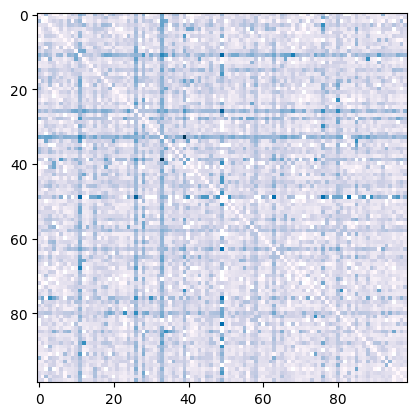

In [14]:
dissimilarities = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')
plt.imshow(dissimilarities, cmap='PuBu')

In [15]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
cluster_labels = clusterer.fit_predict(np.nan_to_num(dissimilarities))
clusters = np.unique(cluster_labels)

print(len(clusters), 'clusters found')
for cl in clusters:
    print(f'Cluster # {cl} :{len(np.where(cluster_labels==cl)[0])} epochs') 
    

3 clusters found
Cluster # -1 :54 epochs
Cluster # 0 :12 epochs
Cluster # 1 :33 epochs


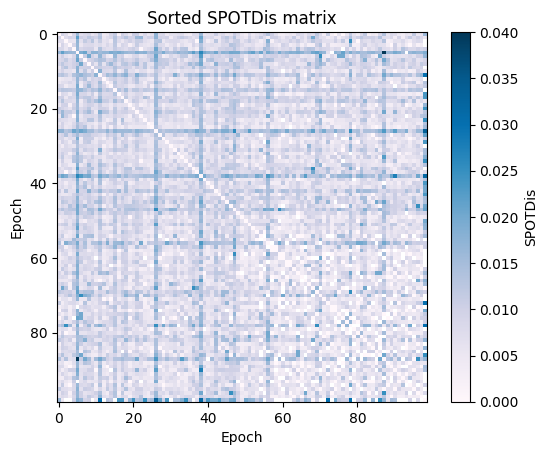

In [16]:
si = np.argsort(cluster_labels)
plt.title('Sorted SPOTDis matrix')
plt.imshow(dissimilarities[:, si][si], cmap='PuBu')
plt.colorbar().set_label('SPOTDis')
plt.xlabel('Epoch')
plt.ylabel('Epoch');

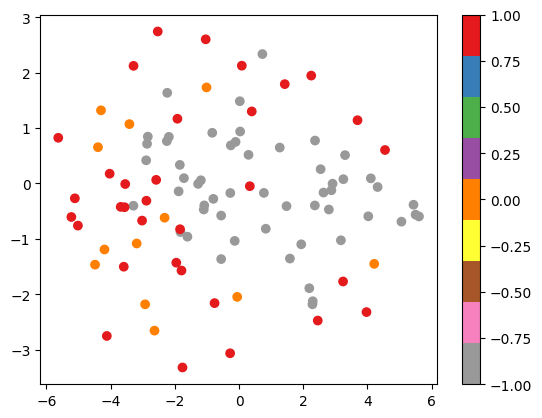

In [18]:
embedding = TSNE(n_components=2).fit_transform(np.nan_to_num(dissimilarities))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Set1_r', c=cluster_labels)
plt.colorbar()

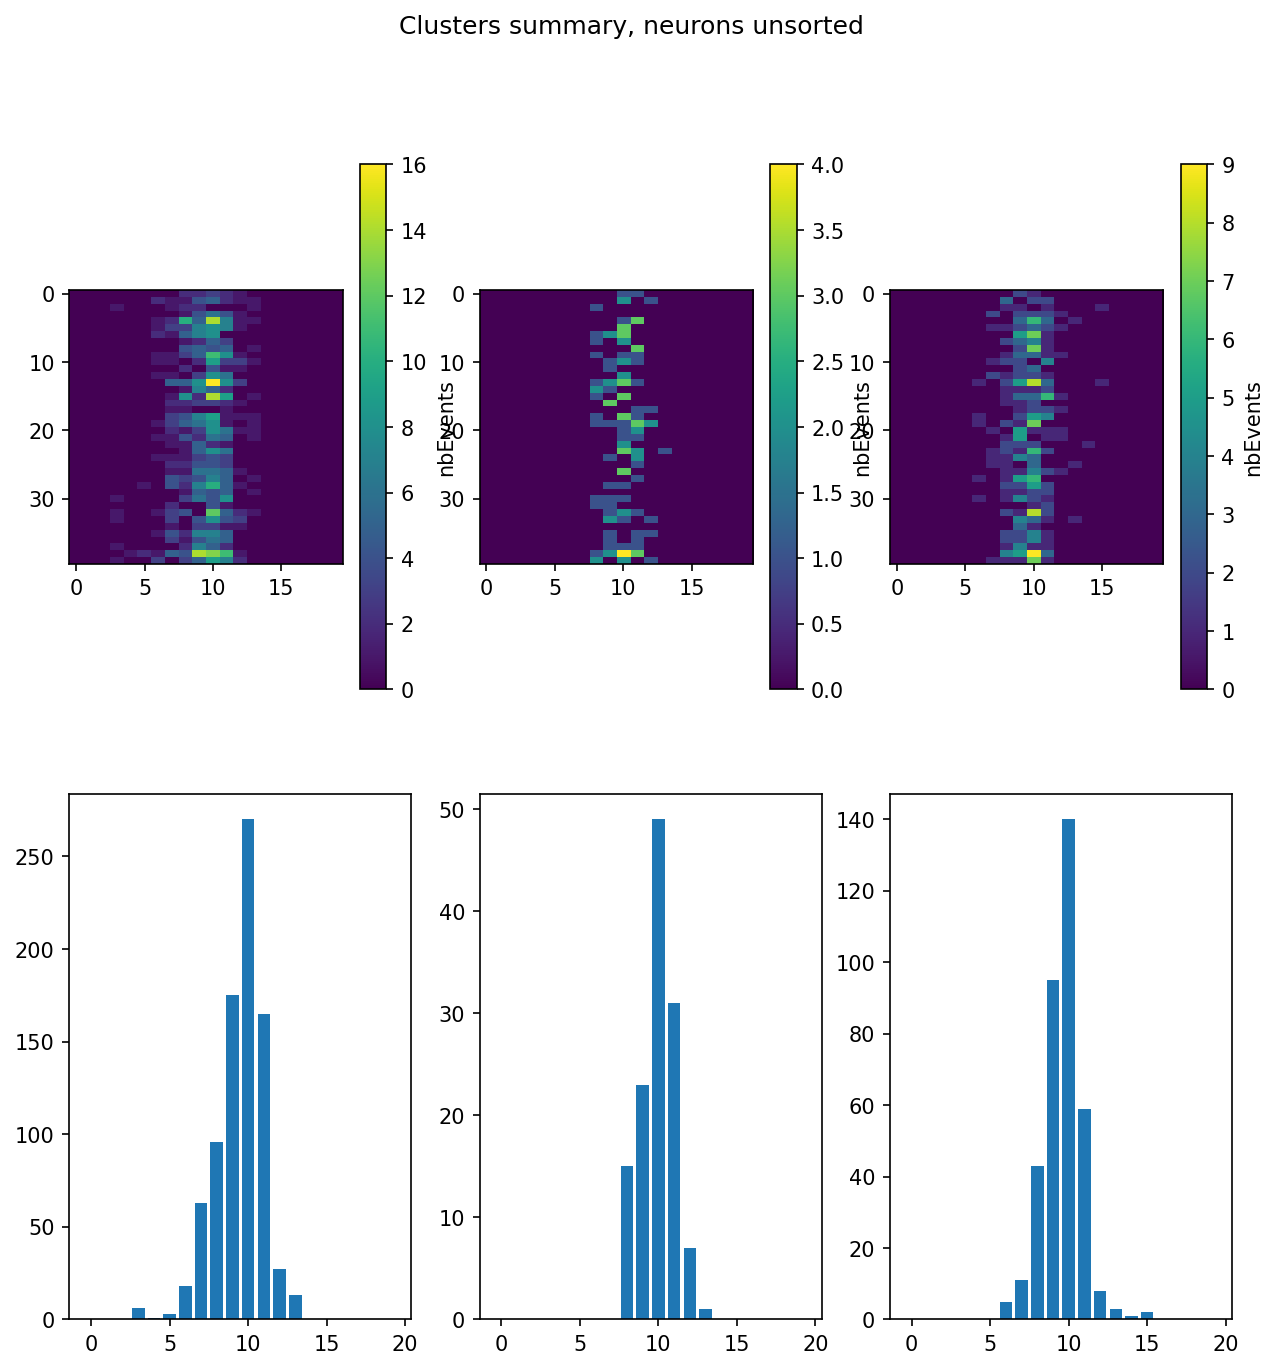

In [17]:
#show events distribution in clusters made of ripple and random epochs
cluster_event_sums = []    
n_clust = len(clusters)
figure, axes = plt.subplots(2,n_clust, figsize=(10, 10), dpi=150)
figure.suptitle('Clusters summary, neurons unsorted')
for icl, clust in enumerate(clusters):
    events2d = np.zeros((n_neurons, duration_frames))
    for nb_epoch in np.where(cluster_labels==clust)[0]:
        for i_neuron, neuron in enumerate(ii_spike_times[nb_epoch]):
            sp_indices = spike_times[neuron[0]:neuron[1]]
            for ind in sp_indices:
                events2d[i_neuron, int(ind*fps)] += 1
    plot = axes[0, icl].imshow(events2d, aspect = 0.5) 
    plt.colorbar(plot, ax=axes[0, icl]).set_label('nbEvents')
    axes[1, icl].bar(np.linspace(0,19,20), np.sum(events2d, axis = 0))
    cluster_event_sums.append(events2d)
    

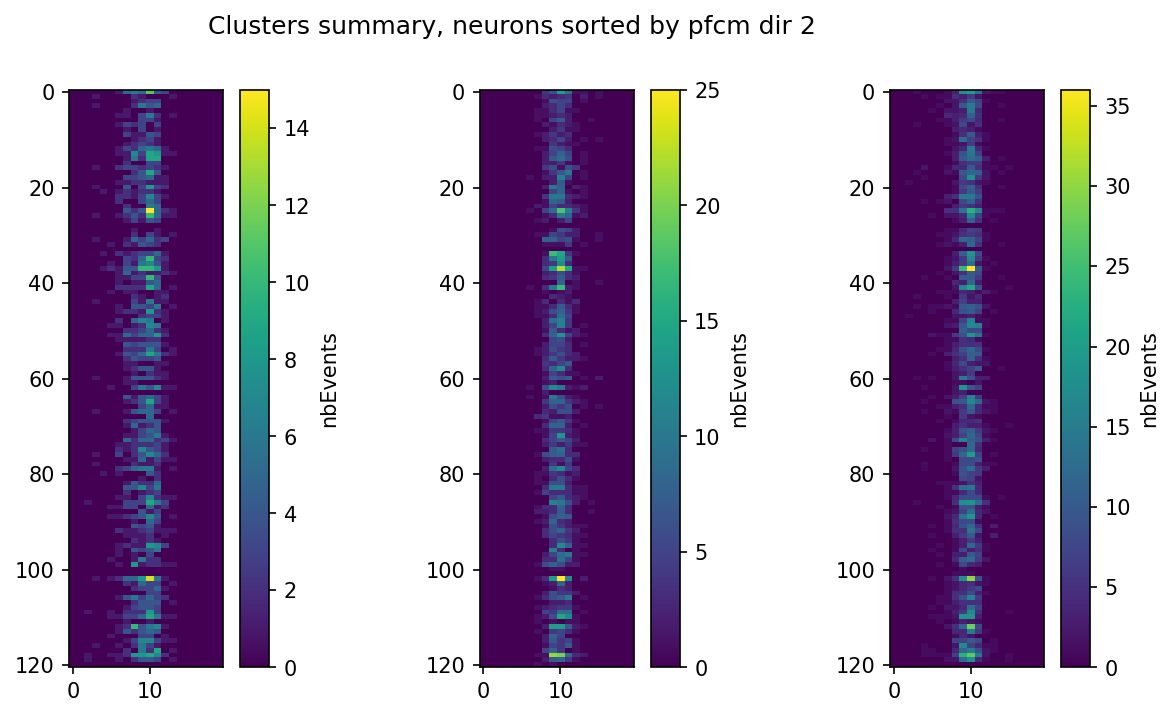

In [27]:
#show events distribution in clusters made of ripple and random epochs
figure, axes = plt.subplots(1,n_clust, figsize=(10, 5), dpi=150)
figure.suptitle('Clusters summary, neurons sorted by pfcm dir 2')
for icl, clust_sum in enumerate(cluster_event_sums):
    #order = np.argsort(first_times)
    first_times = [0 if not np.count_nonzero(row) else np.nonzero(row)[0][0] for row in clust_sum]
    #order = np.argsort(first_times)
    plot = axes[icl].imshow(clust_sum[order, :], aspect = 0.62) 
    plt.colorbar(plot, ax=axes[icl]).set_label('nbEvents')


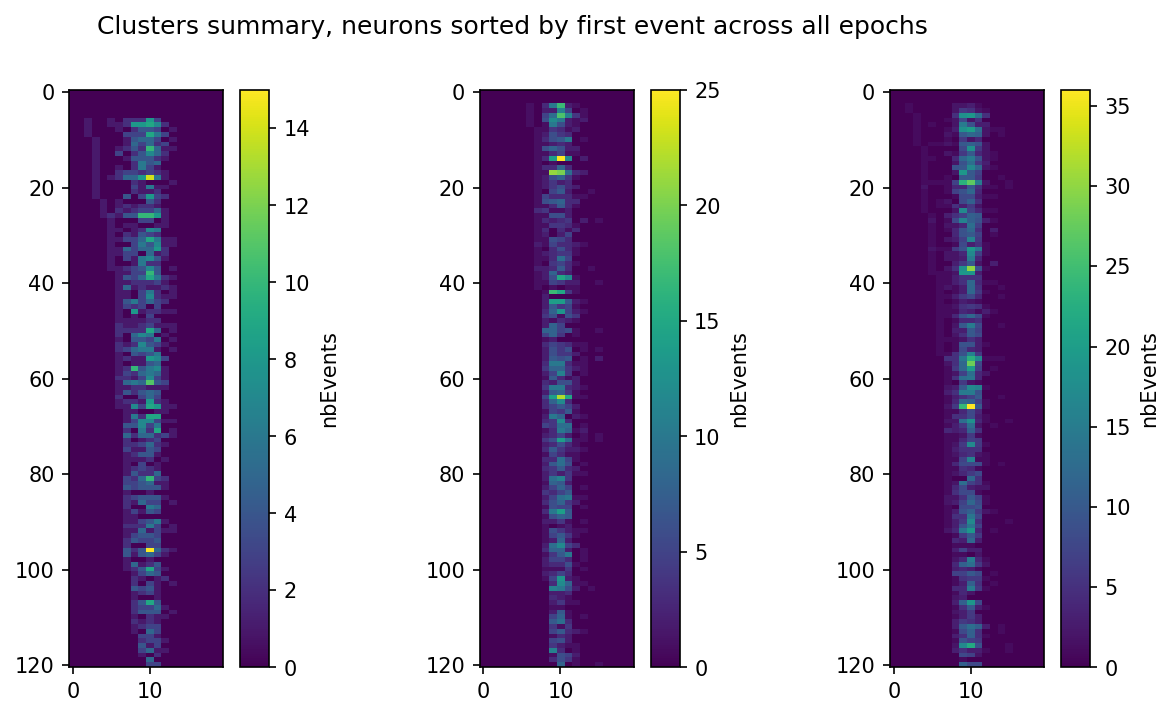

In [29]:
#show events distribution in clusters made of ripple and random epochs
figure, axes = plt.subplots(1,n_clust, figsize=(10, 5), dpi=150)
figure.suptitle('Clusters summary, neurons sorted by first event across all epochs')
for icl, clust_sum in enumerate(cluster_event_sums):
    first_times = [0 if not np.count_nonzero(row) else np.nonzero(row)[0][0] for row in clust_sum]
    order = np.argsort(first_times)
    plot = axes[icl].imshow(clust_sum[order, :], aspect = 0.62) 
    plt.colorbar(plot, ax=axes[icl]).set_label('nbEvents')


In [1]:
#Sort epochs by Kendall's Tau Sortedness measure OR by Sperman Ranking test
ep_order = []
for cl in clusters:
    ep_sortedness = []
    cl_indices = np.where(cluster_labels==cl)[0]
    for i_epoch, epoch in enumerate(ii_spike_times[cl_indices]):
        active = [i for i, row in enumerate(epoch) if row[0] != row[1]]
        cim = [np.mean(spike_times[row[0]:row[1]]) for row in epoch] 
        neur_order = np.argsort([cim[i] for i in active])   #order by c.m. of activation times (only active neurons are taken!!)
        loc_col_order = np.argsort([pfcm[pfdir][i] for i in active]) 
        #ep_sortedness.append(kendalltau(neur_order, col_order)[0])
        ep_sortedness.append(spearmanr(neur_order, loc_col_order).correlation)
    ep_order.append(np.argsort(ep_sortedness))

NameError: name 'clusters' is not defined

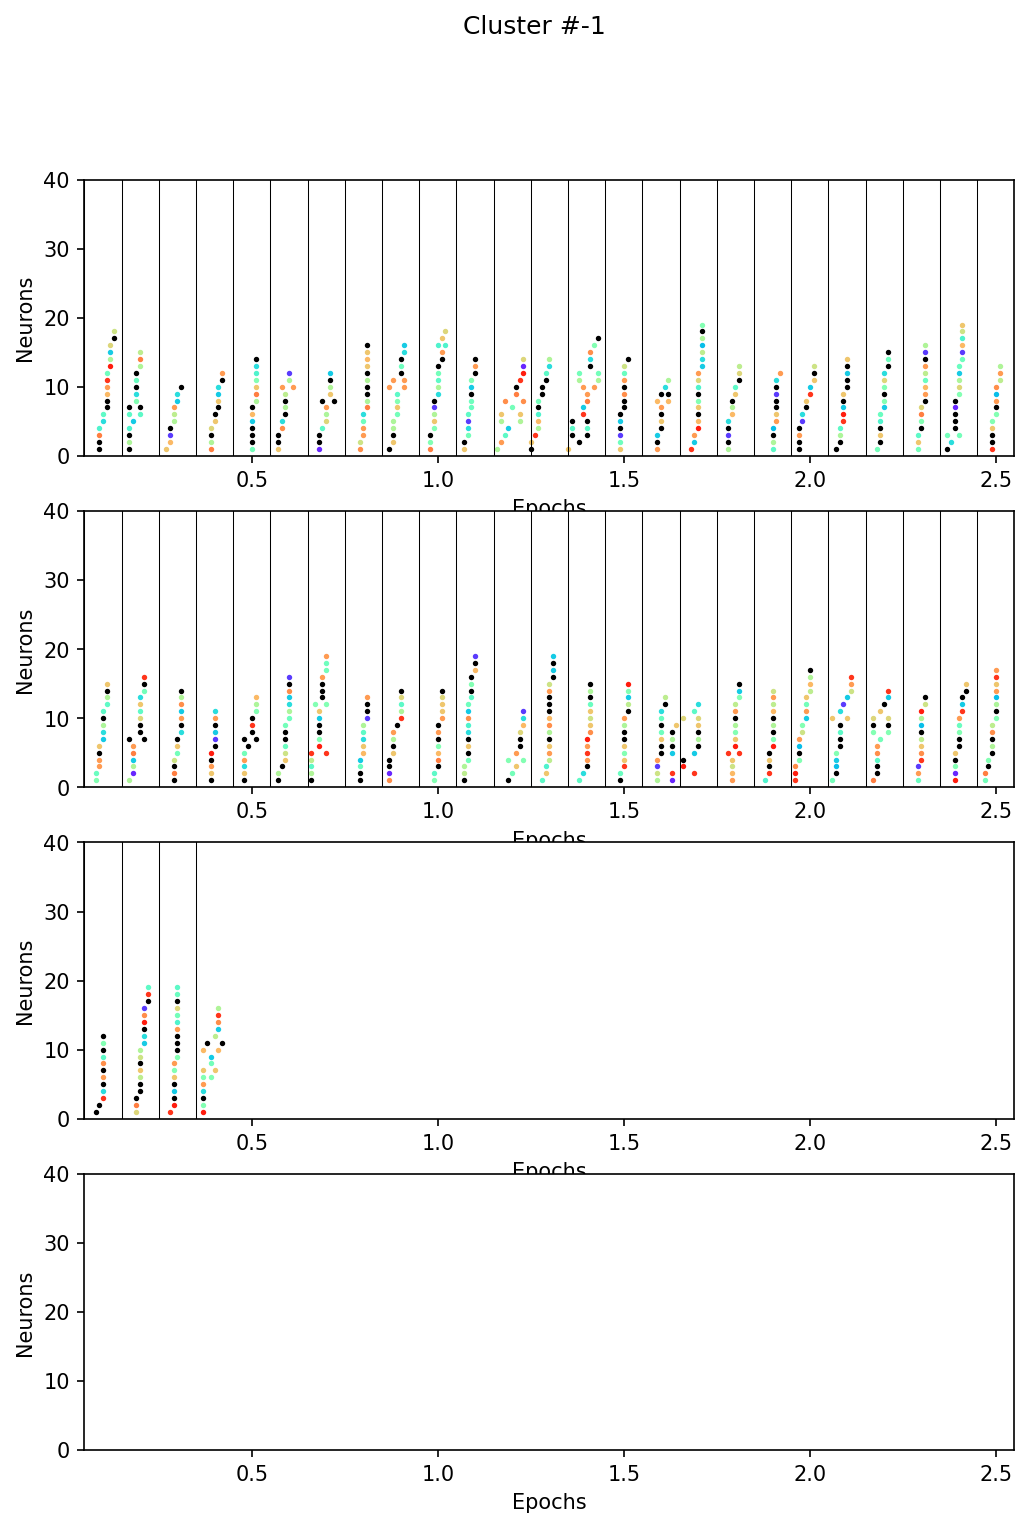

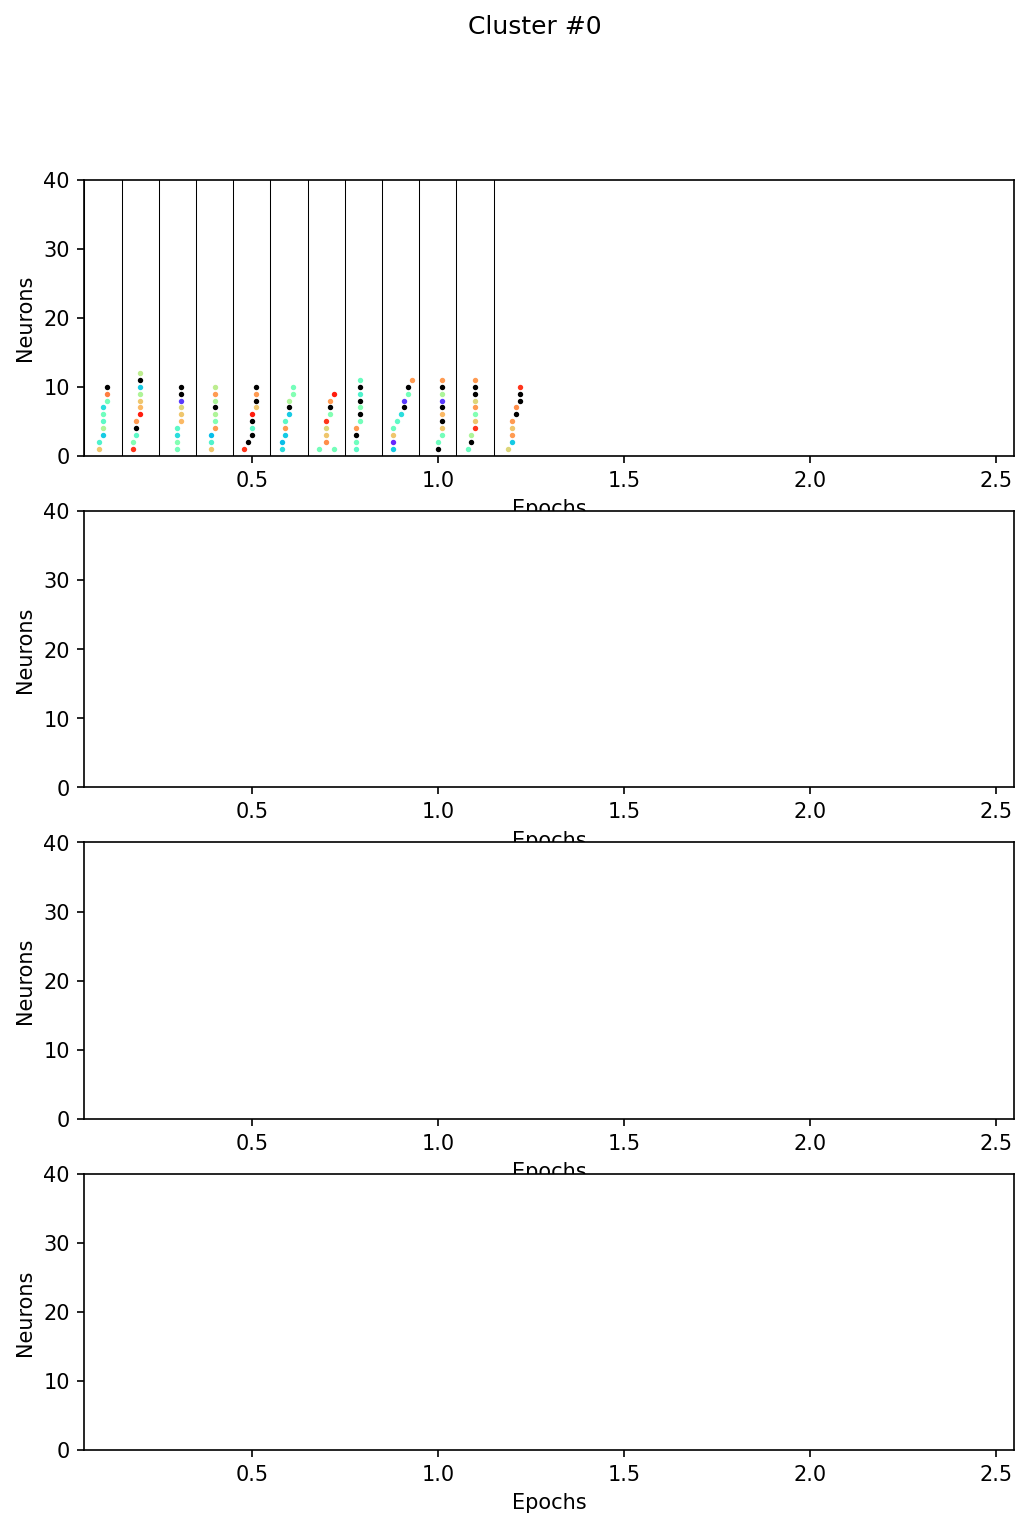

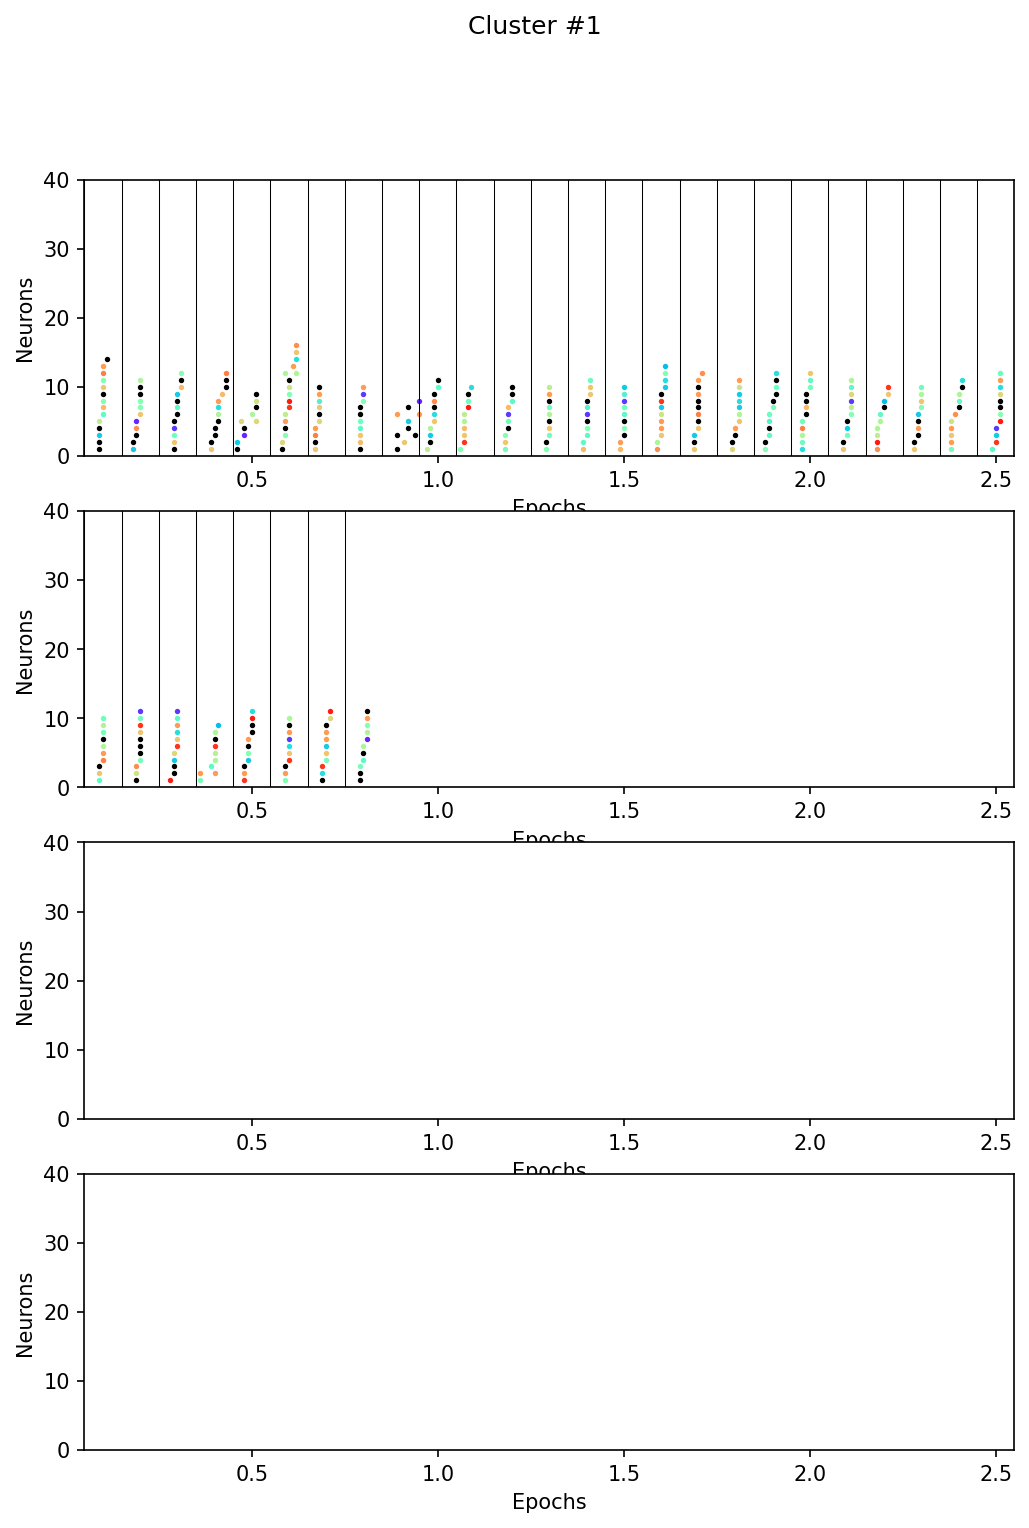

In [21]:
#Plot raster map of all epochs in .pdf files 
interval = 0.1 #length between epoch centers on the plot
eps_per_row = 25 #number of epochs per row
eps_per_col = 4  #number of epochs per column
eps_per_fig = eps_per_row*eps_per_col

pdf = PdfPages(root + 'Chrp_spearmanr_dir0.pdf')

for i_cl, cl in enumerate(clusters):
    cl_indices = np.where(cluster_labels==cl)[0]
    n_pages = int(len(cl_indices)/eps_per_fig) + 1
    for page in range(n_pages):
        fig, axes = plt.subplots(eps_per_col, 1, figsize = (8,11), dpi = 150)
        fig.suptitle('Cluster #' + str(cl))
        for a, ax in enumerate(axes):
            #ax.set_xticks(np.linspace(interval, eps_per_row*interval, eps_per_row), labels = [str(i + a*eps_per_row + page*eps_per_fig) for i in range(eps_per_row)])
            ax.set_xlim(interval*0.5, interval*(eps_per_row + 0.5))
            ax.set_ylim(0, n_neurons)
            ax.set_xlabel('Epochs')
            ax.set_ylabel('Neurons')
                         
        for i_epoch, epoch in enumerate(ii_spike_times[cl_indices[ep_order[i_cl]][page*eps_per_fig: min((page +1)*eps_per_fig, len(cl_indices))]]):
            row = int(i_epoch/eps_per_row)
            col = i_epoch%eps_per_row
            axes[row].axvline(interval*(col + 0.5), c = 'black', linewidth=0.5)
            
            cim = [np.mean(spike_times[row[0]:row[1]]) for row in epoch] 
            order = np.argsort(cim)
            for i_neuron, neuron in enumerate(epoch[order]):
                spikes = np.array(spike_times[neuron[0]:neuron[1]])
                axes[row].scatter(spikes + interval*col, np.ones(len(spikes))+i_neuron, color=colors[order[i_neuron]], marker='.', s=10)
        pdf.savefig()
pdf.close()

<h1>Sandbox</h1>

In [44]:
shape = (269,272)
thres = 0.5
color = np.array([1,0,1])
A = sleep_mat['ExtractedResults']['A'][0][0][:,5].todense().reshape(shape)
B = (A/np.max(A) > thres)
B = np.moveaxis(np.array(([B,]*3))*1.0, 0, 2)*color

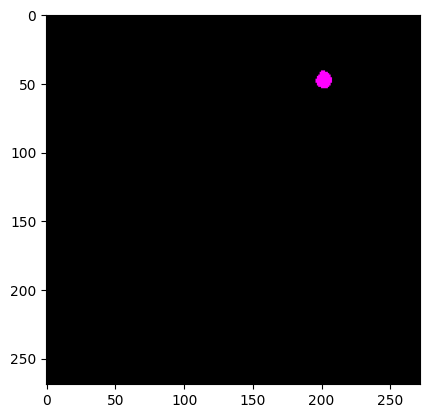

In [45]:
plt.imshow(B)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 2000x1000 with 0 Axes>

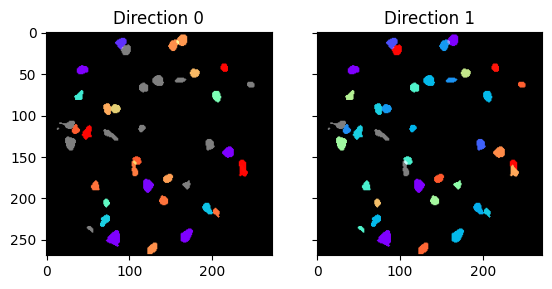

In [55]:
#Plot all selected neurons on the FOV and color them with respect to their PFs in both directions separately
shape = (269,272)
thres = 0.5
dirlen = {0:93, 1:96}

plt.figure(figsize = (20,10), dpi = 100)
fig, axes = plt.subplots(1,2, sharey = True)

for pfdir in range(2):
    colors = [[0.5,0.5,0.5] if np.isnan(pf) else colormap.rainbow(pf/dirlen[pfdir])[:3] for pf in pfcm[pfdir]]
    IM = np.zeros((*shape, 3))
    for i_neur, neur in enumerate(pc_list):
        A = sleep_mat['ExtractedResults']['A'][0][0][:,neur].todense().reshape(shape)
        A = (A/np.max(A) > thres)
        IM += np.moveaxis(np.array(([A,]*3))*1.0, 0, 2)*colors[i_neur]
    axes[pfdir].imshow(IM)
    axes[pfdir].set_title(f'Direction {pfdir}')
